# 2. Creating the consort diagrams for the Therlid dataset

This notebook walks throught the creation of consort diagrams for the Therlid dataset.

## Defines and Imports

In [ ]:
# replace with own projectid to pull from bigquery
%env GOOGLE_CLOUD_PROJECT = aiwonglab

env: GOOGLE_CLOUD_PROJECT=aiwonglab


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files
from google.cloud import bigquery

import missingno as msno
import matplotlib.pyplot as plt

from google.colab import auth
auth.authenticate_user()
print('Authenticated')
import warnings
warnings.filterwarnings("ignore")


%load_ext google.colab.data_table

Authenticated


In [ ]:
# temperature values and window for pairing
lower_tempc = 30
upper_tempc = 45
# time window in hours
lenient_time_window = 2
strict_time_window = 1

# base date to create temperature pairs using the intial year for eICU2
base_date = pd.Timestamp('2019-01-01')
# base date to create temperature pairs using the intial year for eICU
base_date_eicu = pd.Timestamp('2014-01-01')

# fill
mimic_iv = {}
eicu = {}
eicu2 = {}

# fill
# consort_mimic_iv = {}
# consort_eicu = {}
# consort_eicu2 = {}

# variables to create temperature pairs
temp_pairs_vars = [
    'patientunitstayid',
    'nursingchartoffset',
    'Temp_C',
    'Temp_F'
]
temp_pairs_vars_mimic = [
    'stay_id',
    'Temp_C',
    'Temp_F'
]

eicu_cols = [
    'patientunitstayid',
    'datetime_charted',
    'Temp_C',
    'nursingchartoffset'
]
mimiciv_cols = [
    'stay_id',
    'subject_id',
    'hadm_id',
    'Temp_C',
    'charttime'
]

# temperature location mappings
temperature_location_mappings = {}
# dictionary mappings to identify correct temperature location recorded
temperature_location_mappings['eicu'] = {
    'temporal': [
        'Temporal', 'te,poral', 'teemporal', 'tem', 'tem[oral', 'tem[poral', 'temoporal', 'temoporol',
        'temopral', 'temoral', 'temp', 'temp  art', 'temp art', 'temp artery', 'temp at',
        'temp, art', 'temp.', 'tempa rt',
        'tempart', 'temperal',
        'temple', 'tempm art', 'tempoal', 'tempoarl', 'tempoeral', 'tempoiral', 'tempooral', 'tempor',
        'tempora', 'tempora;', 'temporak', 'temporal', 'temporal ', 'temporal  artery', 'temporal art',
        'temporal artery', 'temporal artery scan', 'temporal scan', 'temporal,', 'temporalf', 'temporarl',
        'temporol', 'temporral', 'temporsl', 'tempota', 'tempral', 'temprl', 'temproal', 'temproral',
        'tenporal', 'termporal', 'tewmporal', 'tmp', 'tmporal', '.ta', 'ta', 'forehead', ' temporal',
        'tymporal'
    ],
    'oral': [
        'Oral', 'o', 'o.', 'oal', 'oarl', 'olral', 'or', 'or ', 'or36.6al', 'ora', 'ora;', 'orak', 'oral',
        'oral ', 'oral/axillary', 'oral3.', 'oral49', 'orala', 'orall', 'orally', 'orl', 'orla', 'orsl',
        'otal'
    ],
    'core': [
        'Core', 'core', 'pa catheter', 'esophageal', 'esophageal probe', 'temperature sensing urinary catheter',
        'intravascular (swan)', 'core urinary catheter', 'bladder', 'eso', 'core temperature', 'bladr', 'foley ',
        'gastric tube, oral', 'bldr', 'foley', 'f.', 'foley', 'bldr', 'esoph', 'catheter', 'pa cath',
        'core central line', '.swan', 'esophageal ', 'pa', 'intravascular', 'swan', 'swan ganz', 'esophogeal',
        'esphageal', 'core ', 'foley temp'
    ],
    'rectal': [
        'rc', 'rctal', 're', 'rec', 'rec ', 'rec.', 'recatl', 'recrtal', 'rect', 'recta', 'recta;', 'rectaal',
        'rectal', 'rectal ', 'rectal  probe', 'rectal temp probe and foley temp probe', 'rectal;', 'rectall',
        'rectally', 'rectoal', 'rectsl', 'r', 'r.', '.rec'
    ],
    'other': [
        'axillary', 'axilla', 'ax', 'axllry', 'axi', 'axl', 'ax ', 'axilalry', 'axillaru', 'axilary'
    ],
    'tympanic': [
        'tympanic', 'tym', 'tymp', 'tempanic'
    ]
}

## Functions

In [ ]:
# grabs and reads spreadsheets
def get_vars_df(sheet_id, gid):

  return pd.read_csv(f'https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid={gid}')

## Patient Demographics

### MIMIC-IV

In [ ]:
%%bigquery mimic_iv_pat

SELECT DISTINCT
    icu.subject_id
  , icu.hadm_id
  , icu.stay_id
  , CASE WHEN icu.gender = "F" THEN 1 ELSE 0 END AS sex_female
  , icu.race AS race_ethnicity

-- ICU stays
FROM physionet-data.mimiciv_derived.icustay_detail
AS icu

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
sheets_id = "1ppZG7GSJaScPmko34GOAN_6c-VwumrytonGQmvWpuLM"
gid = "1877090341"

mimic_iv_map = get_vars_df(sheets_id, gid)

mapping_series = mimic_iv_map.set_index('original')['mapping']

# map the 'race_ethnicity' column in the 'mimic_iv_pat' DataFrame
mimic_iv_pat['race_ethnicity'] = mimic_iv_pat['race_ethnicity'].map(mapping_series)

In [ ]:
x = mimic_iv_pat.groupby('subject_id').first().reset_index()

mimic_iv['dist_original'] = pd.crosstab(x['race_ethnicity'],
                                                x['sex_female'],
                                                normalize=True) * 100

mimic_iv['dist_original'] = mimic_iv['dist_original'].round(2)

mimic_iv['dist_original']

sex_female,0,1
race_ethnicity,,
American Indian / Alaska Native,0.09,0.08
Asian,1.64,1.31
Black,4.20,4.88
Hispanic OR Latino,1.98,1.51
More Than One Race,0.05,0.05
Native Hawaiian / Pacific Islander,0.10,0.06
Unknown,9.72,6.63
White,38.06,29.62


In [ ]:
mimic_iv_pat

,subject_id,hadm_id,stay_id,sex_female,race_ethnicity
0,16671253,27961922,33708525,1,Hispanic OR Latino
1,16754217,20804421,38876887,0,Asian
2,14678144,20703865,39375515,0,Native Hawaiian / Pacific Islander
3,19094927,28061512,31557994,0,Native Hawaiian / Pacific Islander
4,16254738,26192634,39909282,0,Hispanic OR Latino
...,...,...,...,...,...
73176,10938709,23365864,36291707,0,Hispanic OR Latino
73177,18186075,24395600,39960194,1,Hispanic OR Latino
73178,13894867,21178289,35096787,0,Hispanic OR Latino
73179,13894867,27560658,32361619,0,Hispanic OR Latino


In [ ]:
pd.crosstab(
    mimic_iv_pat['race_ethnicity'],
    mimic_iv_pat['sex_female']
)

sex_female,0,1
race_ethnicity,,
American Indian / Alaska Native,70,70
Asian,1221,934
Black,3593,4367
Hispanic OR Latino,1634,1171
More Than One Race,38,30
Native Hawaiian / Pacific Islander,69,41
Unknown,5946,4106
White,28247,21644


In [ ]:
len(mimic_iv_pat["hadm_id"].unique())

66239

In [ ]:
n = len(x)
print(n)
mimic_iv['n_original'] = n

50920


### eICU-CRD

In [ ]:
%%bigquery eicu_pat

SELECT DISTINCT
  icu.uniquepid AS subject_id
, icu.patienthealthsystemstayid
, icu.patientunitstayid
, CASE WHEN pat.gender = "Female" THEN 1 ELSE 0 END AS sex_female
, pat.ethnicity AS race_ethnicity

-- ICU stays
FROM `physionet-data.eicu_crd_derived.icustay_detail`
AS icu

-- patient information
LEFT JOIN `physionet-data.eicu_crd.patient`
AS pat
ON pat.patientunitstayid = icu.patientunitstayid

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
sheets_id = "1ppZG7GSJaScPmko34GOAN_6c-VwumrytonGQmvWpuLM"
gid = "622977158"

eicu_map = get_vars_df(sheets_id, gid)

mapping_series = eicu_map.set_index('original')['mapping']

eicu_pat['race_ethnicity'] = eicu_pat['race_ethnicity'].map(mapping_series)
eicu_pat['race_ethnicity'] = eicu_pat['race_ethnicity'].fillna('Unknown')

In [ ]:
x = eicu_pat.groupby('subject_id').first()

eicu['dist_original'] = pd.crosstab(x['race_ethnicity'],
                                            x['sex_female'],
                                            normalize=True) * 100

eicu['dist_original'] = eicu['dist_original'].round(2)

eicu['dist_original']

sex_female,0,1
race_ethnicity,,
American Indian / Alaska Native,0.35,0.34
Asian,0.88,0.80
Black,5.41,5.11
Hispanic OR Latino,2.00,1.75
Unknown,3.53,2.52
White,41.87,35.42


In [ ]:
len(eicu_pat["patienthealthsystemstayid"].unique())

166355

In [ ]:
(pd.crosstab(
    eicu_pat['race_ethnicity'],
    eicu_pat['sex_female'],
    normalize=True
) * 100).round(2)

sex_female,0,1
race_ethnicity,,
American Indian / Alaska Native,0.43,0.42
Asian,0.85,0.78
Black,5.43,5.18
Hispanic OR Latino,2.00,1.71
Unknown,3.41,2.48
White,41.93,35.38


In [ ]:
pd.crosstab(
    eicu_pat['race_ethnicity'],
    eicu_pat['sex_female']
)

sex_female,0,1
race_ethnicity,,
American Indian / Alaska Native,854,846
Asian,1711,1559
Black,10901,10407
Hispanic OR Latino,4024,3440
Unknown,6846,4986
White,84220,71065


In [ ]:
n = len(x)
print(n)
eicu['n_original'] = n

139367


### eICU-CRD2

In [ ]:
%%bigquery eicu2_pat

SELECT DISTINCT
  icu.uniquepid AS subject_id,
  icu.patienthealthsystemstayid,
  icu.patientunitstayid,
  CASE
    WHEN icu.age = '> 89' THEN CAST(90 AS STRING)
    ELSE icu.age
  END AS age_admission,
  CASE
    WHEN pat.gender = "Female" THEN 1
    ELSE 0
  END AS sex_female,
  icu.admissionweight AS weight_admission,
  icu.admissionheight AS height_admission,
  pat.ethnicity AS race_ethnicity
FROM
  `eicu_crd_ii_v0_1_0_derived.icustay_detail` AS icu
LEFT JOIN
  `eicu_crd_ii_v0_1_0.patient` AS pat
ON
  pat.patienthealthsystemstayid = icu.patienthealthsystemstayid;

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
len(eicu2_pat["subject_id"].unique())

94340

In [ ]:
len(eicu2_pat["patienthealthsystemstayid"].unique())

173229

In [ ]:
sheets_id = "1ppZG7GSJaScPmko34GOAN_6c-VwumrytonGQmvWpuLM"
gid = "422286429"

eicu2_map = get_vars_df(sheets_id, gid)

mapping_series = eicu2_map.set_index('original')['mapping']

eicu2_pat['race_ethnicity'] = eicu2_pat['race_ethnicity'].map(mapping_series)
eicu2_pat['race_ethnicity'] = eicu2_pat['race_ethnicity'].fillna('Unknown')

In [ ]:
# eicu2 has different patients holding the same unique subject id, generate a unique subject id for them
columns_for_uniqueness = ['height_admission', 'age_admission', 'sex_female', 'subject_id']

eicu2_pat['group_id'] = eicu2_pat.groupby(columns_for_uniqueness).ngroup()

eicu2_pat['subject_id_with_suffix'] = eicu2_pat['subject_id'] + '-' + eicu2_pat['group_id'].astype(str)

eicu2_pat = eicu2_pat.drop('group_id', axis=1)

eicu2_pat = eicu2_pat.drop('subject_id', axis=1)
eicu2_pat = eicu2_pat.rename(columns={'subject_id_with_suffix': 'subject_id'})

In [ ]:
x = eicu2_pat.groupby('subject_id').first()

eicu2['dist_original'] = pd.crosstab(x['race_ethnicity'],
                                            x['sex_female'],
                                            normalize=True) * 100

eicu2['dist_original'] = eicu2['dist_original'].round(2)

eicu2['dist_original']

sex_female,0,1
race_ethnicity,,
American Indian / Alaska Native,0.56,0.46
Asian,1.21,0.88
Black,5.72,5.32
Hispanic OR Latino,2.11,1.68
Unknown,5.59,3.93
White,40.74,31.82


In [ ]:
(pd.crosstab(
    eicu2_pat['race_ethnicity'],
    eicu2_pat['sex_female'],
    normalize=True
) * 100).round(2)

sex_female,0,1
race_ethnicity,,
American Indian / Alaska Native,0.62,0.48
Asian,1.20,0.85
Black,5.63,5.27
Hispanic OR Latino,2.20,1.73
Unknown,5.37,3.70
White,41.04,31.92


In [ ]:
pd.crosstab(
    eicu2_pat['race_ethnicity'],
    eicu2_pat['sex_female']
)

sex_female,0,1
race_ethnicity,,
American Indian / Alaska Native,1251,975
Asian,2423,1712
Black,11365,10632
Hispanic OR Latino,4437,3482
Unknown,10827,7459
White,82781,64383


In [ ]:
len(eicu2_pat["patienthealthsystemstayid"].unique())

173229

In [ ]:
n = len(x)
print(n)
eicu2['n_original'] = n

167694


In [ ]:
#patients < hospitlaizaions < pairs

## Temperature Pairs

### MIMIC-IV

In [ ]:
%%bigquery mimiciv_temperature --project spring-carving-271217

Select *
FROM (
  SELECT subject_id,
         hadm_id,
         stay_id,
         charttime,
         di2.label,
         value
  FROM `physionet-data.mimiciv_icu.chartevents` ce
  LEFT JOIN `physionet-data.mimiciv_icu.d_items` di2 ON di2.itemid = ce.itemid
  WHERE ce.itemid IN (
      SELECT itemid
      FROM `physionet-data.mimiciv_icu.d_items` di
      WHERE (
          (linksto = 'chartevents')
          and
          di.category in ('Respiratory', 'Routine Vital Signs')
          and
          di.label in (
              'Temperature Celsius', 'Temperature Fahrenheit', 'Temperature Site'
              )
          )
    )

  )
  PIVOT (
    ANY_VALUE(value)
    FOR label IN (
            'Temperature Celsius', 'Temperature Fahrenheit', 'Temperature Site'
      )

  )
ORDER BY subject_id ASC, hadm_id ASC, charttime ASC

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
mimiciv_temperature['Temperature Site'] = mimiciv_temperature['Temperature Site'].str.lower()
mimiciv_temperature.rename(columns={'Temperature Fahrenheit': 'Temp_F', 'Temperature Celsius': 'Temp_C'}, inplace=True)
mimiciv_temperature[temp_pairs_vars_mimic] = mimiciv_temperature[temp_pairs_vars_mimic].apply(pd.to_numeric, downcast='integer')
# round to one decimal point for both Celcius and Farenheit temperatures
mimiciv_temperature["Temp_C"] = round(mimiciv_temperature["Temp_C"], 1)
mimiciv_temperature["Temp_F"] = round(mimiciv_temperature["Temp_F"], 1)

# if Temp_F is missing but Temp_C is not convert to Temp_F using Temp_C and vice versa
mimiciv_temperature.loc[mimiciv_temperature['Temp_F'].isna() & mimiciv_temperature['Temp_C'].notna(), 'Temp_F'] = round(mimiciv_temperature['Temp_C'] * 9/5 + 32, 1)
mimiciv_temperature.loc[mimiciv_temperature['Temp_C'].isna() & mimiciv_temperature['Temp_F'].notna(), 'Temp_C'] = round((mimiciv_temperature['Temp_F'] - 32) * 5/9, 1)
# drop any NA values still present as temperatures cannot be used
# since these should be pairs of NA values, dropping one of the targeted columns should suffice
mimiciv_cleaned = mimiciv_temperature.dropna(subset=['Temp_C'])
# filter rows where 'Temp_C' is within the range [30, 45] at a later time for flow diagram
# mimiciv_cleaned = mimiciv_cleaned[(mimiciv_cleaned['Temp_C'] >= 30) & (mimiciv_cleaned['Temp_C'] <= 45)]
print(
    'unique subjects with temperatures: ',
    len(mimiciv_cleaned['stay_id'].unique().tolist())
)

unique subjects with temperatures:  72502


#### Temporal

In [ ]:
mimiciv_temp_temporal = mimiciv_cleaned.loc[
    mimiciv_cleaned['Temperature Site'] == "temporal",
    mimiciv_cols
].rename(columns={
    'Temp_C': 'temp_c_temporal',
    'charttime': 'charttime_temporal'
}).sort_values(by=[
    'charttime_temporal'
]).copy()

mimiciv_temp_temporal = mimiciv_temp_temporal.dropna().copy()

In [ ]:
# grab temps later need to discuss/think what to put
# can maybe do n_temporal but don't have time its already pretty late
# mimic_iv['abgs']

#### Oral

In [ ]:
# filter and prepare the rectal temperature data
mimiciv_temp_oral = mimiciv_cleaned.loc[
    mimiciv_cleaned['Temperature Site'] == "oral",
    mimiciv_cols
].rename(columns={
    'Temp_C': 'temp_c_oral',
    'charttime': 'charttime_oral'
}).sort_values(by=[
    'charttime_oral',
]).copy()

# drop rows with null values
mimiciv_temp_oral = mimiciv_temp_oral.loc[mimiciv_temp_oral.notnull().all(axis=1), :]

#### Core

In [ ]:
# filter and prepare the core temperature data
mimiciv_temp_core = mimiciv_cleaned.loc[
    mimiciv_cleaned['Temperature Site'] == "esophogeal",
    mimiciv_cols
].rename(columns={
    'Temp_C': 'temp_c_core',
    'charttime': 'charttime_core'
}).sort_values(by=[
    'charttime_core',
]).copy()

# drop rows with null values
mimiciv_temp_core = mimiciv_temp_core.loc[mimiciv_temp_core.notnull().all(axis=1), :]

#### Rectal

In [ ]:
# filter and prepare the rectal temperature data
mimiciv_temp_rectal = mimiciv_cleaned.loc[
    mimiciv_cleaned['Temperature Site'] == "rectal",
    mimiciv_cols
].rename(columns={
    'Temp_C': 'temp_c_rectal',
    'charttime': 'charttime_rectal'
}).sort_values(by=[
    'charttime_rectal',
]).copy()

# drop rows with null values
mimiciv_temp_rectal = mimiciv_temp_rectal.loc[mimiciv_temp_rectal.notnull().all(axis=1), :]

### eICU-CRD

In [ ]:
# pull temperatures from nurse chart table
%%bigquery eicu_temperature --project spring-carving-271217

SELECT *
FROM (
  SELECT
    patientunitstayid,
    nursingchartoffset,
    nursingchartcelltypevallabel,
    nursingchartcelltypevalname,
    nursingchartvalue
  FROM
    `physionet-data.eicu_crd.nursecharting`
  WHERE
    nursingchartcelltypevallabel IN ('Temperature')
)
PIVOT (
  ANY_VALUE(nursingchartvalue)
  FOR nursingchartcelltypevalname IN (
    'Temperature (C)' AS Temp_C,
    'Temperature (F)' AS Temp_F,
    'Temperature Location' AS Temp_Location
  )
)
WHERE
  Temp_Location IS NOT NULL

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
eicu_temperature['Temp_Location'] = eicu_temperature['Temp_Location'].str.lower()
# conform to the correct data type
eicu_temperature[temp_pairs_vars] = eicu_temperature[temp_pairs_vars].apply(pd.to_numeric, downcast='integer')
# round to one decimal point for both Celcius and Farenheit temperatures
eicu_temperature["Temp_C"] = round(eicu_temperature["Temp_C"], 1)
eicu_temperature["Temp_F"] = round(eicu_temperature["Temp_F"], 1)

eicu_temperature.loc[eicu_temperature['Temp_F'].isna() & eicu_temperature['Temp_C'].notna(), 'Temp_F'] = round(eicu_temperature['Temp_C'] * 9/5 + 32, 1)
eicu_temperature.loc[eicu_temperature['Temp_C'].isna() & eicu_temperature['Temp_F'].notna(), 'Temp_C'] = round((eicu_temperature['Temp_F'] - 32) * 5/9, 1)
# drop any NA values still present as temperatures cannot be used
# since these should be pairs of NA values, dropping one of the targeted columns should suffice
eicu_cleaned = eicu_temperature.dropna(subset=['Temp_C'])

In [ ]:
# apply mappings to conform them to proper temperature locations
for key in temperature_location_mappings['eicu']:
  eicu_cleaned.loc[
    eicu_cleaned['Temp_Location'].isin(temperature_location_mappings['eicu'][key]),
      'Temp_Location_' + key] = 1
  eicu_cleaned.loc[
    eicu_cleaned['Temp_Location'].isin(temperature_location_mappings['eicu'][key]),
      'Temp_Location_mapped' ] = key
# drop any observations that haven't been mapped
eicu_cleaned = eicu_cleaned.dropna(subset=['Temp_Location_mapped'])
print(
    'unique subjects with temperatures: ',
    len(eicu_cleaned['patientunitstayid'].unique().tolist())
)

unique subjects with temperatures:  148910


In [ ]:
eicu_cleaned['datetime_charted'] = base_date_eicu + pd.to_timedelta(eicu_cleaned['nursingchartoffset'], unit='m')

#### Temporal

In [ ]:
# filter and prepare the temporal temperature data
eicu_temp_temporal = eicu_cleaned.loc[
    eicu_cleaned['Temp_Location_temporal'] == 1,
    eicu_cols
].rename(columns={
    'Temp_C': 'temp_c_temporal',
    'datetime_charted': 'datetime_charted_temporal',
}).sort_values(by=[
    'datetime_charted_temporal',
]).copy()

# drop rows with null values
eicu_temp_temporal = eicu_temp_temporal.loc[eicu_temp_temporal.notnull().all(axis=1), :]

#### Oral

In [ ]:
# filter and prepare the oral temperature data
eicu_temp_oral = eicu_cleaned.loc[
    eicu_cleaned['Temp_Location_oral'] == 1,
    eicu_cols
].rename(columns={
    'Temp_C': 'temp_c_oral',
    'datetime_charted': 'datetime_charted_oral',
    'nursingchartoffset': 'nursingchartoffset_oral'
}).sort_values(by=[
    'datetime_charted_oral',
]).copy()

# drop rows with null values
eicu_temp_oral = eicu_temp_oral.loc[eicu_temp_oral.notnull().all(axis=1), :]

#### Core

In [ ]:
# filter and prepare the core temperature data
eicu_temp_core = eicu_cleaned.loc[
    eicu_cleaned['Temp_Location_core'] == 1,
    eicu_cols
].rename(columns={
    'Temp_C': 'temp_c_core',
    'datetime_charted': 'datetime_charted_core',
    'nursingchartoffset': 'nursingchartoffset_core'
}).sort_values(by=[
    'datetime_charted_core',
]).copy()

# drop rows with null values
eicu_temp_core = eicu_temp_core.loc[eicu_temp_core.notnull().all(axis=1), :]

#### Rectal

In [ ]:
# filter and prepare the rectal temperature data
eicu_temp_rectal = eicu_cleaned.loc[
    eicu_cleaned['Temp_Location_rectal'] == 1,
    eicu_cols
].rename(columns={
    'Temp_C': 'temp_c_rectal',
    'datetime_charted': 'datetime_charted_rectal',
    'nursingchartoffset': 'nursingchartoffset_rectal'
}).sort_values(by=[
    'datetime_charted_rectal',
]).copy()

# drop rows with null values
eicu_temp_rectal = eicu_temp_rectal.loc[eicu_temp_rectal.notnull().all(axis=1), :]

In [ ]:
# grab counts of temporal, oral, rectal, and core
# then make pairs with lenient time window and long tiem window
# use flow diagrams to make it

### eICU-CRD2

In [ ]:
# pull temperatures from nurse chart table
%%bigquery eicu2_temperature --project aiwonglab
SELECT * from
(

SELECT patientunitstayid,
nursingchartoffset,
nursingchartcelltypevallabel,
nursingchartcelltypevalname,
nursingchartvalue
FROM `aiwonglab.eicu_crd_ii_v0_1_0.nursecharting`
WHERE nursingchartcelltypevallabel in ('Temperature')

)

PIVOT (
  ANY_VALUE(nursingchartvalue)
  FOR nursingchartcelltypevalname IN (
            'Temperature (C)' as Temp_C,
            'Temperature (F)' as Temp_F,
            'Temperature Location' as Temp_Location
      )
)

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
# remove "removed: not cleared" in Temp_C, Temp_F, and Temp_Location
eicu2_temperature = eicu2_temperature[eicu2_temperature['Temp_C'] != "removed: not cleared"]
eicu2_temperature = eicu2_temperature[eicu2_temperature['Temp_F'] != "removed: not cleared"]
eicu2_cleaned = eicu2_temperature[eicu2_temperature['Temp_Location'] != "removed: not cleared"]

In [ ]:
# lower strings to make it easier to match temperature location
eicu2_cleaned['Temp_Location'] = eicu2_cleaned['Temp_Location'].str.lower()
# conform to the correct data type
eicu2_cleaned[temp_pairs_vars] = eicu2_cleaned[temp_pairs_vars].apply(pd.to_numeric, downcast='integer')
# round to one decimal point for both Celcius and Farenheit temperatures
eicu2_cleaned["Temp_C"] = round(eicu2_cleaned["Temp_C"], 1)
eicu2_cleaned["Temp_F"] = round(eicu2_cleaned["Temp_F"], 1)

In [ ]:
# if Temp_F is missing but Temp_C is not convert to Temp_F using Temp_C and vice versa
eicu2_cleaned.loc[eicu2_cleaned['Temp_F'].isna() & eicu2_cleaned['Temp_C'].notna(), 'Temp_F'] = round(eicu2_cleaned['Temp_C'] * 9/5 + 32, 1)
eicu2_cleaned.loc[eicu2_cleaned['Temp_C'].isna() & eicu2_cleaned['Temp_F'].notna(), 'Temp_C'] = round((eicu2_cleaned['Temp_F'] - 32) * 5/9, 1)
# drop any NA values still present as temperatures cannot be used
# since these should be pairs of NA values, dropping one of the targeted columns should suffice
eicu2_cleaned = eicu2_cleaned.dropna(subset=['Temp_C'])

In [ ]:
# apply mappings to conform them to proper temperature locations
# add an indicator to show what has been mapped
for key in temperature_location_mappings['eicu']:
  eicu2_cleaned.loc[
    eicu2_cleaned['Temp_Location'].isin(temperature_location_mappings['eicu'][key]),
      'Temp_Location_' + key] = 1
  eicu2_cleaned.loc[
    eicu2_cleaned['Temp_Location'].isin(temperature_location_mappings['eicu'][key]),
      'Temp_Location_mapped' ] = key
# drop any observations that haven't been mapped
eicu2_cleaned = eicu2_cleaned.dropna(subset=['Temp_Location_mapped'])

In [ ]:
eicu2_cleaned['datetime_charted'] = base_date + pd.to_timedelta(eicu2_cleaned['nursingchartoffset'], unit='m')

#### Temporal

In [ ]:
# filter and prepare the temporal temperature data
eicu2_temp_temporal = eicu2_cleaned.loc[
    eicu2_cleaned['Temp_Location_temporal'] == 1,
    eicu_cols
].rename(columns={
    'Temp_C': 'temp_c_temporal',
    'datetime_charted': 'datetime_charted_temporal',
}).sort_values(by=[
    'datetime_charted_temporal',
]).copy()

# drop rows with null values
eicu2_temp_temporal = eicu2_temp_temporal.loc[eicu2_temp_temporal.notnull().all(axis=1), :]

#### Oral

In [ ]:
# filter and prepare the oral temperature data
eicu2_temp_oral = eicu2_cleaned.loc[
    eicu2_cleaned['Temp_Location_oral'] == 1,
    eicu_cols
].rename(columns={
    'Temp_C': 'temp_c_oral',
    'datetime_charted': 'datetime_charted_oral',
    'nursingchartoffset': 'nursingchartoffset_oral'
}).sort_values(by=[
    'datetime_charted_oral',
]).copy()

# drop rows with null values
eicu2_temp_oral = eicu2_temp_oral.loc[eicu2_temp_oral.notnull().all(axis=1), :]

#### Core

In [ ]:
# filter and prepare the core temperature data
eicu2_temp_core = eicu2_cleaned.loc[
    eicu2_cleaned['Temp_Location_core'] == 1,
    eicu_cols
].rename(columns={
    'Temp_C': 'temp_c_core',
    'datetime_charted': 'datetime_charted_core',
    'nursingchartoffset': 'nursingchartoffset_core'
}).sort_values(by=[
    'datetime_charted_core',
]).copy()

# drop rows with null values
eicu2_temp_core = eicu2_temp_core.loc[eicu2_temp_core.notnull().all(axis=1), :]

#### Rectal

In [ ]:
# filter and prepare the rectal temperature data
eicu2_temp_rectal = eicu2_cleaned.loc[
    eicu2_cleaned['Temp_Location_rectal'] == 1,
    eicu_cols
].rename(columns={
    'Temp_C': 'temp_c_rectal',
    'datetime_charted': 'datetime_charted_rectal',
    'nursingchartoffset': 'nursingchartoffset_rectal'
}).sort_values(by=[
    'datetime_charted_rectal',
]).copy()

# drop rows with null values
eicu2_temp_rectal = eicu2_temp_rectal.loc[eicu2_temp_rectal.notnull().all(axis=1), :]

## Pairs, Lenient Time Window

### MIMIC-IV

#### Temporal-Core



In [ ]:
# perform a left join, need to drop the null values afterwards
mimiciv_merged_core = pd.merge_asof(
    left=mimiciv_temp_temporal,
    right=mimiciv_temp_core,
    left_by='stay_id',
    right_by='stay_id',
    left_on='charttime_temporal',
    right_on='charttime_core',
    tolerance=pd.Timedelta("120m"),
    direction='nearest',
    suffixes=('', '_todrop'),
    allow_exact_matches=True
)

# drop the _todrop columns
columns_to_drop = [col for col in mimiciv_merged_core.columns if '_todrop' in col]
mimiciv_merged_core.drop(columns=columns_to_drop, inplace=True)

# filter to keep only rows with non-null core temperatures
mimiciv_merged_core_final = mimiciv_merged_core.loc[
    mimiciv_merged_core['temp_c_core'].notnull(),
    :
]

In [ ]:
# grab pair counts and record in the dictonary
# go back to the next page and change
mimic_iv['p_temporal-core_lenient_pairs'] = len(mimiciv_merged_core_final)

#### Temporal-Rectal

In [ ]:
# perform a left join, need to drop the null values afterwards
mimiciv_merged_rectal = pd.merge_asof(
    left=mimiciv_temp_temporal,
    right=mimiciv_temp_rectal,
    left_by='stay_id',
    right_by='stay_id',
    left_on='charttime_temporal',
    right_on='charttime_rectal',
    tolerance=pd.Timedelta("120m"),
    direction='nearest',
    suffixes=('', '_todrop'),
    allow_exact_matches=True
)

# drop the _todrop columns
columns_to_drop = [col for col in mimiciv_merged_rectal.columns if '_todrop' in col]
mimiciv_merged_rectal.drop(columns=columns_to_drop, inplace=True)

# filter to keep only rows with non-null core temperatures
mimiciv_merged_rectal_final = mimiciv_merged_rectal.loc[
    mimiciv_merged_rectal['temp_c_rectal'].notnull(),
    :
]

In [ ]:
mimic_iv['p_temporal-rectal_lenient_pairs'] = len(mimiciv_merged_rectal_final)

#### Temporal-Oral


In [ ]:
# perform a left join, need to drop the null values afterwards
mimiciv_merged_oral = pd.merge_asof(
    left=mimiciv_temp_temporal,
    right=mimiciv_temp_oral,
    left_by='stay_id',
    right_by='stay_id',
    left_on='charttime_temporal',
    right_on='charttime_oral',
    tolerance=pd.Timedelta("120m"),
    direction='nearest',
    suffixes=('', '_todrop'),
    allow_exact_matches=True
)

# drop the _todrop columns
columns_to_drop = [col for col in mimiciv_merged_oral.columns if '_todrop' in col]
mimiciv_merged_oral.drop(columns=columns_to_drop, inplace=True)

# filter to keep only rows with non-null core temperatures
mimiciv_merged_oral_final = mimiciv_merged_oral.loc[
    mimiciv_merged_oral['temp_c_oral'].notnull(),
    :
]

In [ ]:
mimic_iv['p_temporal-oral_lenient_pairs'] = len(mimiciv_merged_oral_final)

#### Unify Pairs

In [ ]:
# rename Temp_C_{}, datetime_charted_{}, and add indicator columns for each
mimiciv_merged_rectal_final = mimiciv_merged_rectal_final.rename(columns={'temp_c_rectal': 'temp_c_reference', 'charttime_rectal': 'datetime_charted_reference', 'charttime_temporal': 'datetime_charted_temporal' })
mimiciv_merged_rectal_final["pair_type"] = "temporal-rectal"
mimiciv_merged_core_final = mimiciv_merged_core_final.rename(columns={'temp_c_core': 'temp_c_reference', 'charttime_core': 'datetime_charted_reference', 'charttime_temporal': 'datetime_charted_temporal'})
mimiciv_merged_core_final["pair_type"] = "temporal-core"
mimiciv_merged_oral_final = mimiciv_merged_oral_final.rename(columns={'temp_c_oral': 'temp_c_reference', 'charttime_oral': 'datetime_charted_reference', 'charttime_temporal': 'datetime_charted_temporal'})
mimiciv_merged_oral_final["pair_type"] = "temporal-oral"

In [ ]:
mimiciv_merged_final = pd.concat([mimiciv_merged_rectal_final, mimiciv_merged_core_final, mimiciv_merged_oral_final], axis=0)

In [ ]:
mimic_iv['p_lenient_pairs'] = len(mimiciv_merged_final)

In [ ]:
mimic_iv_pairs_pats = mimiciv_merged_final.merge(
                  mimic_iv_pat.drop(["subject_id"], axis=1),
                  on=['hadm_id', 'stay_id']
                    )

In [ ]:
x = mimic_iv_pairs_pats.groupby('subject_id').first()

mimic_iv['dist_lenient_pairs'] = pd.crosstab(x['race_ethnicity'],
                                             x['sex_female'],
                                             normalize=True) * 100

mimic_iv['dist_lenient_pairs'] = mimic_iv['dist_lenient_pairs'].round(2)

mimic_iv['dist_lenient_pairs']

sex_female,0,1
race_ethnicity,,
American Indian / Alaska Native,0.30,0.12
Asian,1.79,1.31
Black,4.95,5.31
Hispanic OR Latino,1.79,1.97
Native Hawaiian / Pacific Islander,0.24,0.24
Unknown,11.57,8.35
White,36.20,25.88


### eICU-CRD

#### Temporal-Core

In [ ]:
# perform a left join, need to drop the null values afterwards
eicu_merged_core = pd.merge_asof(
    left=eicu_temp_temporal,
    right=eicu_temp_core,
    left_by='patientunitstayid',
    right_by='patientunitstayid',
    left_on='datetime_charted_temporal',
    right_on='datetime_charted_core',
    tolerance=pd.Timedelta("120m"),
    direction='nearest',
    suffixes=('', '_todrop'),
    allow_exact_matches=True
)

# filter to keep only rows with non-null core temperatures
eicu_merged_core_final = eicu_merged_core.loc[
    eicu_merged_core['temp_c_core'].notnull(),
    :
]

In [ ]:
eicu['p_temporal-core_lenient_pairs'] = len(eicu_merged_core_final)

#### Temporal-Rectal

In [ ]:
# perform a left join, need to drop the null values afterwards
eicu_merged_rectal = pd.merge_asof(
    left=eicu_temp_temporal,
    right=eicu_temp_rectal,
    left_by='patientunitstayid',
    right_by='patientunitstayid',
    left_on='datetime_charted_temporal',
    right_on='datetime_charted_rectal',
    tolerance=pd.Timedelta("120m"),
    direction='nearest',
    suffixes=('', '_todrop'),
    allow_exact_matches=True
)

# filter to keep only rows with non-null temperatures
eicu_merged_rectal_final = eicu_merged_rectal.loc[
    eicu_merged_rectal['temp_c_rectal'].notnull(),
    :
]

In [ ]:
eicu['p_temporal-rectal_lenient_pairs'] = len(eicu_merged_rectal_final)

#### Temporal-Oral

In [ ]:
# perform a left join, need to drop the null values afterwards
eicu_merged_oral = pd.merge_asof(
    left=eicu_temp_temporal,
    right=eicu_temp_oral,
    left_by='patientunitstayid',
    right_by='patientunitstayid',
    left_on='datetime_charted_temporal',
    right_on='datetime_charted_oral',
    tolerance=pd.Timedelta("120m"),
    direction='nearest',
    suffixes=('', '_todrop'),
    allow_exact_matches=True
)


# filter to keep only rows with non-null temperatures
eicu_merged_oral_final = eicu_merged_oral.loc[
    eicu_merged_oral['temp_c_oral'].notnull(),
    :
]

In [ ]:
eicu['p_temporal-oral_lenient_pairs'] = len(eicu_merged_oral_final)

#### Unify Pairs

In [ ]:
eicu_merged_rectal_final = eicu_merged_rectal_final.rename(columns={'temp_c_rectal': 'temp_c_reference', 'datetime_charted_rectal': 'datetime_charted_reference', 'nursingchartoffset_rectal': 'nursingchartoffset_reference'})
eicu_merged_rectal_final["pair_type"] = "temporal-rectal"
eicu_merged_core_final = eicu_merged_core_final.rename(columns={'temp_c_core': 'temp_c_reference', 'datetime_charted_core': 'datetime_charted_reference', 'nursingchartoffset_core': 'nursingchartoffset_reference'})
eicu_merged_core_final["pair_type"] = "temporal-core"
eicu_merged_oral_final = eicu_merged_oral_final.rename(columns={'temp_c_oral': 'temp_c_reference', 'datetime_charted_oral': 'datetime_charted_reference', 'nursingchartoffset_oral': 'nursingchartoffset_reference'})
eicu_merged_oral_final["pair_type"] = "temporal-oral"

In [ ]:
eicu_merged_final = pd.concat([eicu_merged_rectal_final, eicu_merged_core_final, eicu_merged_oral_final], axis=0)

In [ ]:
eicu['p_lenient_pairs'] = len(eicu_merged_final)

In [ ]:
eicu_pairs_pats = eicu_merged_final.merge(
    eicu_pat,
    left_on='patientunitstayid',
    right_on='patientunitstayid',
    how='left'
)

In [ ]:
x = eicu_pairs_pats.groupby('subject_id').first()

eicu['dist_lenient_pairs'] = pd.crosstab(x['race_ethnicity'],
                                             x['sex_female'],
                                             normalize=True) * 100

eicu['dist_lenient_pairs'] = eicu['dist_lenient_pairs'].round(2)

eicu['dist_lenient_pairs']

sex_female,0,1
race_ethnicity,,
American Indian / Alaska Native,0.45,0.21
Asian,0.42,0.43
Black,2.99,2.77
Hispanic OR Latino,1.51,1.40
Unknown,2.51,1.92
White,46.86,38.53


### eICU-CRD2

#### Temporal-Core

In [ ]:
# perform a left join, need to drop the null values afterwards
eicu2_merged_core = pd.merge_asof(
    left=eicu2_temp_temporal,
    right=eicu2_temp_core,
    left_by='patientunitstayid',
    right_by='patientunitstayid',
    left_on='datetime_charted_temporal',
    right_on='datetime_charted_core',
    tolerance=pd.Timedelta("120m"),
    direction='nearest',
    suffixes=('', '_todrop'),
    allow_exact_matches=True
)

# filter to keep only rows with non-null core temperatures
eicu2_merged_core_final = eicu2_merged_core.loc[
    eicu2_merged_core['temp_c_core'].notnull(),
    :
]

In [ ]:
eicu2['p_temporal-core_lenient_pairs'] = len(eicu2_merged_core_final)

#### Temporal-Rectal

In [ ]:
# perform a left join, need to drop the null values afterwards
eicu2_merged_rectal = pd.merge_asof(
    left=eicu2_temp_temporal,
    right=eicu2_temp_rectal,
    left_by='patientunitstayid',
    right_by='patientunitstayid',
    left_on='datetime_charted_temporal',
    right_on='datetime_charted_rectal',
    tolerance=pd.Timedelta("120m"),
    direction='nearest',
    suffixes=('', '_todrop'),
    allow_exact_matches=True
)

# filter to keep only rows with non-null core temperatures
eicu2_merged_rectal_final = eicu2_merged_rectal.loc[
    eicu2_merged_rectal['temp_c_rectal'].notnull(),
    :
]

In [ ]:
eicu2['p_temporal-rectal_lenient_pairs'] = len(eicu2_merged_rectal_final)

#### Temporal-Oral

In [ ]:
# perform a left join, need to drop the null values afterwards
eicu2_merged_oral = pd.merge_asof(
    left=eicu2_temp_temporal,
    right=eicu2_temp_oral,
    left_by='patientunitstayid',
    right_by='patientunitstayid',
    left_on='datetime_charted_temporal',
    right_on='datetime_charted_oral',
    tolerance=pd.Timedelta("120m"),
    direction='nearest',
    suffixes=('', '_todrop'),
    allow_exact_matches=True
)


# filter to keep only rows with non-null core temperatures
eicu2_merged_oral_final = eicu2_merged_oral.loc[
    eicu2_merged_oral['temp_c_oral'].notnull(),
    :
]

In [ ]:
eicu2['p_temporal-oral_lenient_pairs'] = len(eicu2_merged_oral_final)

#### Unify Pairs

In [ ]:
# rename Temp_C_{}, datetime_charted_{}, and add indicator columns for each
eicu2_merged_rectal_final = eicu2_merged_rectal_final.rename(columns={'temp_c_rectal': 'temp_c_reference', 'datetime_charted_rectal': 'datetime_charted_reference', 'nursingchartoffset_rectal': 'nursingchartoffset_reference'})
eicu2_merged_rectal_final["pair_type"] = "temporal-rectal"
eicu2_merged_core_final = eicu2_merged_core_final.rename(columns={'temp_c_core': 'temp_c_reference', 'datetime_charted_core': 'datetime_charted_reference', 'nursingchartoffset_core': 'nursingchartoffset_reference'})
eicu2_merged_core_final["pair_type"] = "temporal-core"
eicu2_merged_oral_final = eicu2_merged_oral_final.rename(columns={'temp_c_oral': 'temp_c_reference', 'datetime_charted_oral': 'datetime_charted_reference', 'nursingchartoffset_oral': 'nursingchartoffset_reference'})
eicu2_merged_oral_final["pair_type"] = "temporal-oral"

In [ ]:
# concat dataframes into one unified dataframe
eicu2_merged_final = pd.concat([eicu2_merged_rectal_final, eicu2_merged_core_final, eicu2_merged_oral_final], axis=0)

In [ ]:
eicu2['p_lenient_pairs'] = len(eicu2_merged_final)

In [ ]:
eicu2_pairs_pats = eicu2_merged_final.merge(
    eicu2_pat,
    left_on='patientunitstayid',
    right_on='patientunitstayid',
    how='left'
)

In [ ]:
x = eicu2_pairs_pats.groupby('subject_id').first()

eicu2['dist_lenient_pairs'] = pd.crosstab(x['race_ethnicity'],
                                             x['sex_female'],
                                             normalize=True) * 100

eicu2['dist_lenient_pairs'] = eicu2['dist_lenient_pairs'].round(2)

eicu2['dist_lenient_pairs']

sex_female,0,1
race_ethnicity,,
American Indian / Alaska Native,0.31,0.38
Asian,1.52,1.07
Black,7.98,7.79
Hispanic OR Latino,1.14,0.90
Unknown,4.60,3.14
White,38.24,32.93


## Pairs, Strict Time Window

### MIMIC-IV

#### Temporal-Core


In [ ]:
# perform a left join, need to drop the null values afterwards
mimiciv_merged_core = pd.merge_asof(
    left=mimiciv_temp_temporal,
    right=mimiciv_temp_core,
    left_by='stay_id',
    right_by='stay_id',
    left_on='charttime_temporal',
    right_on='charttime_core',
    tolerance=pd.Timedelta("60m"),
    direction='nearest',
    suffixes=('', '_todrop'),
    allow_exact_matches=True
)

# drop the _todrop columns
columns_to_drop = [col for col in mimiciv_merged_core.columns if '_todrop' in col]
mimiciv_merged_core.drop(columns=columns_to_drop, inplace=True)

# filter to keep only rows with non-null core temperatures
mimiciv_merged_core_final = mimiciv_merged_core.loc[
    mimiciv_merged_core['temp_c_core'].notnull(),
    :
]

In [ ]:
mimic_iv['p_temporal-core_strict_pairs'] = len(mimiciv_merged_core_final)

#### Temporal-Rectal

In [ ]:
# perform a left join, need to drop the null values afterwards
mimiciv_merged_rectal = pd.merge_asof(
    left=mimiciv_temp_temporal,
    right=mimiciv_temp_rectal,
    left_by='stay_id',
    right_by='stay_id',
    left_on='charttime_temporal',
    right_on='charttime_rectal',
    tolerance=pd.Timedelta("60m"),
    direction='nearest',
    suffixes=('', '_todrop'),
    allow_exact_matches=True
)

# drop the _todrop columns
columns_to_drop = [col for col in mimiciv_merged_rectal.columns if '_todrop' in col]
mimiciv_merged_rectal.drop(columns=columns_to_drop, inplace=True)

# filter to keep only rows with non-null core temperatures
mimiciv_merged_rectal_final = mimiciv_merged_rectal.loc[
    mimiciv_merged_rectal['temp_c_rectal'].notnull(),
    :
]

In [ ]:
mimic_iv['p_temporal-rectal_strict_pairs'] = len(mimiciv_merged_rectal_final)

#### Temporal-Oral

In [ ]:
# perform a left join, need to drop the null values afterwards
mimiciv_merged_oral = pd.merge_asof(
    left=mimiciv_temp_temporal,
    right=mimiciv_temp_oral,
    left_by='stay_id',
    right_by='stay_id',
    left_on='charttime_temporal',
    right_on='charttime_oral',
    tolerance=pd.Timedelta("60m"),
    direction='nearest',
    suffixes=('', '_todrop'),
    allow_exact_matches=True
)

# drop the _todrop columns
columns_to_drop = [col for col in mimiciv_merged_oral.columns if '_todrop' in col]
mimiciv_merged_oral.drop(columns=columns_to_drop, inplace=True)

# filter to keep only rows with non-null core temperatures
mimiciv_merged_oral_final = mimiciv_merged_oral.loc[
    mimiciv_merged_oral['temp_c_oral'].notnull(),
    :
]

In [ ]:
mimic_iv['p_temporal-oral_strict_pairs'] = len(mimiciv_merged_oral_final)

#### Unify Pairs

In [ ]:
# rename Temp_C_{}, datetime_charted_{}, and add indicator columns for each
mimiciv_merged_rectal_final = mimiciv_merged_rectal_final.rename(columns={'temp_c_rectal': 'temp_c_reference', 'charttime_rectal': 'datetime_charted_reference', 'charttime_temporal': 'datetime_charted_temporal' })
mimiciv_merged_rectal_final["pair_type"] = "temporal-rectal"
mimiciv_merged_core_final = mimiciv_merged_core_final.rename(columns={'temp_c_core': 'temp_c_reference', 'charttime_core': 'datetime_charted_reference', 'charttime_temporal': 'datetime_charted_temporal'})
mimiciv_merged_core_final["pair_type"] = "temporal-core"
mimiciv_merged_oral_final = mimiciv_merged_oral_final.rename(columns={'temp_c_oral': 'temp_c_reference', 'charttime_oral': 'datetime_charted_reference', 'charttime_temporal': 'datetime_charted_temporal'})
mimiciv_merged_oral_final["pair_type"] = "temporal-oral"

In [ ]:
mimiciv_merged_final = pd.concat([mimiciv_merged_rectal_final, mimiciv_merged_core_final, mimiciv_merged_oral_final], axis=0)

In [ ]:
mimic_iv['p_strict_pairs'] = len(mimiciv_merged_final)

In [ ]:
mimic_iv_pairs_pats = mimiciv_merged_final.merge(
                  mimic_iv_pat.drop(["subject_id"], axis=1),
                  on=['hadm_id', 'stay_id']
                    )

In [ ]:
x = mimic_iv_pairs_pats.groupby('subject_id').first()

mimic_iv['dist_strict_pairs'] = pd.crosstab(x['race_ethnicity'],
                                             x['sex_female'],
                                             normalize=True) * 100

mimic_iv['dist_strict_pairs'] = mimic_iv['dist_strict_pairs'].round(2)

mimic_iv['dist_strict_pairs']

sex_female,0,1
race_ethnicity,,
American Indian / Alaska Native,0.22,0.11
Asian,1.74,1.85
Black,4.46,4.46
Hispanic OR Latino,2.18,2.07
Native Hawaiian / Pacific Islander,0.33,0.33
Unknown,12.40,8.38
White,34.82,26.66


### eICU-CRD

#### Temporal-Core

In [ ]:
# perform a left join, need to drop the null values afterwards
eicu_merged_core = pd.merge_asof(
    left=eicu_temp_temporal,
    right=eicu_temp_core,
    left_by='patientunitstayid',
    right_by='patientunitstayid',
    left_on='datetime_charted_temporal',
    right_on='datetime_charted_core',
    tolerance=pd.Timedelta("60m"),
    direction='nearest',
    suffixes=('', '_todrop'),
    allow_exact_matches=True
)

# filter to keep only rows with non-null core temperatures
eicu_merged_core_final = eicu_merged_core.loc[
    eicu_merged_core['temp_c_core'].notnull(),
    :
]

In [ ]:
eicu['p_temporal-core_strict_pairs'] = len(eicu_merged_core_final)

#### Temporal-Rectal

In [ ]:
# perform a left join, need to drop the null values afterwards
eicu_merged_rectal = pd.merge_asof(
    left=eicu_temp_temporal,
    right=eicu_temp_rectal,
    left_by='patientunitstayid',
    right_by='patientunitstayid',
    left_on='datetime_charted_temporal',
    right_on='datetime_charted_rectal',
    tolerance=pd.Timedelta("60m"),
    direction='nearest',
    suffixes=('', '_todrop'),
    allow_exact_matches=True
)

# filter to keep only rows with non-null temperatures
eicu_merged_rectal_final = eicu_merged_rectal.loc[
    eicu_merged_rectal['temp_c_rectal'].notnull(),
    :
]

In [ ]:
eicu['p_temporal-rectal_strict_pairs'] = len(eicu_merged_rectal_final)

#### Temporal-Oral

In [ ]:
# perform a left join, need to drop the null values afterwards
eicu_merged_oral = pd.merge_asof(
    left=eicu_temp_temporal,
    right=eicu_temp_oral,
    left_by='patientunitstayid',
    right_by='patientunitstayid',
    left_on='datetime_charted_temporal',
    right_on='datetime_charted_oral',
    tolerance=pd.Timedelta("60m"),
    direction='nearest',
    suffixes=('', '_todrop'),
    allow_exact_matches=True
)


# filter to keep only rows with non-null temperatures
eicu_merged_oral_final = eicu_merged_oral.loc[
    eicu_merged_oral['temp_c_oral'].notnull(),
    :
]

In [ ]:
eicu['p_temporal-oral_strict_pairs'] = len(eicu_merged_oral_final)

#### Unify Pairs

In [ ]:
eicu_merged_rectal_final = eicu_merged_rectal_final.rename(columns={'temp_c_rectal': 'temp_c_reference', 'datetime_charted_rectal': 'datetime_charted_reference', 'nursingchartoffset_rectal': 'nursingchartoffset_reference'})
eicu_merged_rectal_final["pair_type"] = "temporal-rectal"
eicu_merged_core_final = eicu_merged_core_final.rename(columns={'temp_c_core': 'temp_c_reference', 'datetime_charted_core': 'datetime_charted_reference', 'nursingchartoffset_core': 'nursingchartoffset_reference'})
eicu_merged_core_final["pair_type"] = "temporal-core"
eicu_merged_oral_final = eicu_merged_oral_final.rename(columns={'temp_c_oral': 'temp_c_reference', 'datetime_charted_oral': 'datetime_charted_reference', 'nursingchartoffset_oral': 'nursingchartoffset_reference'})
eicu_merged_oral_final["pair_type"] = "temporal-oral"

In [ ]:
eicu_merged_final = pd.concat([eicu_merged_rectal_final, eicu_merged_core_final, eicu_merged_oral_final], axis=0)

In [ ]:
eicu['p_strict_pairs'] = len(eicu_merged_final)

In [ ]:
eicu_pairs_pats = eicu_merged_final.merge(
    eicu_pat,
    left_on='patientunitstayid',
    right_on='patientunitstayid',
    how='left'
)

In [ ]:
x = eicu_pairs_pats.groupby('subject_id').first()

eicu['dist_strict_pairs'] = pd.crosstab(x['race_ethnicity'],
                                             x['sex_female'],
                                             normalize=True) * 100

eicu['dist_strict_pairs'] = eicu['dist_strict_pairs'].round(2)

eicu['dist_strict_pairs']

sex_female,0,1
race_ethnicity,,
American Indian / Alaska Native,0.41,0.27
Asian,0.41,0.49
Black,3.22,3.02
Hispanic OR Latino,1.54,1.50
Unknown,2.40,1.93
White,47.05,37.75


### eICU-CRD2

#### Temporal-Core

In [ ]:
# perform a left join, need to drop the null values afterwards
eicu2_merged_core = pd.merge_asof(
    left=eicu2_temp_temporal,
    right=eicu2_temp_core,
    left_by='patientunitstayid',
    right_by='patientunitstayid',
    left_on='datetime_charted_temporal',
    right_on='datetime_charted_core',
    tolerance=pd.Timedelta("60m"),
    direction='nearest',
    suffixes=('', '_todrop'),
    allow_exact_matches=True
)

# filter to keep only rows with non-null core temperatures
eicu2_merged_core_final = eicu2_merged_core.loc[
    eicu2_merged_core['temp_c_core'].notnull(),
    :
]

In [ ]:
eicu2['p_temporal-core_strict_pairs'] = len(eicu2_merged_core_final)

#### Temporal-Rectal

In [ ]:
# perform a left join, need to drop the null values afterwards
eicu2_merged_rectal = pd.merge_asof(
    left=eicu2_temp_temporal,
    right=eicu2_temp_rectal,
    left_by='patientunitstayid',
    right_by='patientunitstayid',
    left_on='datetime_charted_temporal',
    right_on='datetime_charted_rectal',
    tolerance=pd.Timedelta("60m"),
    direction='nearest',
    suffixes=('', '_todrop'),
    allow_exact_matches=True
)

# filter to keep only rows with non-null core temperatures
eicu2_merged_rectal_final = eicu2_merged_rectal.loc[
    eicu2_merged_rectal['temp_c_rectal'].notnull(),
    :
]

In [ ]:
eicu2['p_temporal-rectal_strict_pairs'] = len(eicu2_merged_rectal_final)

#### Temporal-Oral

In [ ]:
# perform a left join, need to drop the null values afterwards
eicu2_merged_oral = pd.merge_asof(
    left=eicu2_temp_temporal,
    right=eicu2_temp_oral,
    left_by='patientunitstayid',
    right_by='patientunitstayid',
    left_on='datetime_charted_temporal',
    right_on='datetime_charted_oral',
    tolerance=pd.Timedelta("60m"),
    direction='nearest',
    suffixes=('', '_todrop'),
    allow_exact_matches=True
)


# filter to keep only rows with non-null core temperatures
eicu2_merged_oral_final = eicu2_merged_oral.loc[
    eicu2_merged_oral['temp_c_oral'].notnull(),
    :
]

In [ ]:
eicu2['p_temporal-oral_strict_pairs'] = len(eicu2_merged_oral_final)

#### Unify Pairs

In [ ]:
# rename Temp_C_{}, datetime_charted_{}, and add indicator columns for each
eicu2_merged_rectal_final = eicu2_merged_rectal_final.rename(columns={'temp_c_rectal': 'temp_c_reference', 'datetime_charted_rectal': 'datetime_charted_reference', 'nursingchartoffset_rectal': 'nursingchartoffset_reference'})
eicu2_merged_rectal_final["pair_type"] = "temporal-rectal"
eicu2_merged_core_final = eicu2_merged_core_final.rename(columns={'temp_c_core': 'temp_c_reference', 'datetime_charted_core': 'datetime_charted_reference', 'nursingchartoffset_core': 'nursingchartoffset_reference'})
eicu2_merged_core_final["pair_type"] = "temporal-core"
eicu2_merged_oral_final = eicu2_merged_oral_final.rename(columns={'temp_c_oral': 'temp_c_reference', 'datetime_charted_oral': 'datetime_charted_reference', 'nursingchartoffset_oral': 'nursingchartoffset_reference'})
eicu2_merged_oral_final["pair_type"] = "temporal-oral"

In [ ]:
# concat dataframes into one unified dataframe
eicu2_merged_final = pd.concat([eicu2_merged_rectal_final, eicu2_merged_core_final, eicu2_merged_oral_final], axis=0)

In [ ]:
eicu2['p_strict_pairs'] = len(eicu2_merged_final)

In [ ]:
eicu2_pairs_pats = eicu2_merged_final.merge(
    eicu2_pat,
    left_on='patientunitstayid',
    right_on='patientunitstayid',
    how='left'
)

In [ ]:
x = eicu2_pairs_pats.groupby('subject_id').first()

eicu2['dist_strict_pairs'] = pd.crosstab(x['race_ethnicity'],
                                             x['sex_female'],
                                             normalize=True) * 100

eicu2['dist_strict_pairs'] = eicu2['dist_strict_pairs'].round(2)

eicu2['dist_strict_pairs']

sex_female,0,1
race_ethnicity,,
American Indian / Alaska Native,0.36,0.33
Asian,1.60,0.95
Black,7.73,7.95
Hispanic OR Latino,0.95,0.87
Unknown,3.97,2.84
White,38.94,33.50


## Temperature Cut-Offs

### MIMIC-IV

In [ ]:
# grab temp cutoffs
mimiciv_cutoffs = mimic_iv_pairs_pats[
    (mimic_iv_pairs_pats['temp_c_temporal'] >= lower_tempc) &
    (mimic_iv_pairs_pats['temp_c_temporal'] <= upper_tempc) &
    (mimic_iv_pairs_pats['temp_c_reference'] >= lower_tempc) &
    (mimic_iv_pairs_pats['temp_c_reference'] <= upper_tempc)
].copy()

In [ ]:
mimiciv_cutoffs

,stay_id,subject_id,hadm_id,temp_c_temporal,datetime_charted_temporal,temp_c_reference,datetime_charted_reference,pair_type,sex_female,race_ethnicity
0,32414218,15029036,22383141,37.3,2114-05-13 13:00:00,36.2,2114-05-13 13:45:00,temporal-rectal,0,White
1,33372982,13558101,26061249,36.3,2115-01-19 07:13:00,35.5,2115-01-19 08:00:00,temporal-rectal,0,Black
2,33372982,13558101,26061249,36.3,2115-01-19 11:00:00,36.5,2115-01-19 10:00:00,temporal-oral,0,Black
3,36137359,13191989,28038618,36.2,2116-12-12 11:15:00,34.6,2116-12-12 12:00:00,temporal-rectal,0,Black
4,36137359,13191989,28038618,36.2,2116-12-12 11:30:00,34.6,2116-12-12 12:00:00,temporal-rectal,0,Black
...,...,...,...,...,...,...,...,...,...,...
1552,39731216,17055995,26588116,37.1,2205-08-06 16:00:00,36.6,2205-08-06 17:00:00,temporal-oral,0,White
1553,32380994,14454179,28167243,36.8,2206-03-01 19:00:00,36.8,2206-03-01 18:00:00,temporal-oral,1,Black
1554,32380994,14454179,28167243,36.8,2206-03-02 06:00:00,37.1,2206-03-02 07:00:00,temporal-oral,1,Black
1555,32380994,14454179,28167243,36.3,2206-03-02 19:00:00,37.2,2206-03-02 18:00:00,temporal-oral,1,Black


In [ ]:
mimic_iv['p_pairs_cut'] = len(mimiciv_cutoffs)

In [ ]:
x = mimiciv_cutoffs.groupby('subject_id').first()

mimic_iv['dist_pairs_cut'] = pd.crosstab(x['race_ethnicity'],
                                                 x['sex_female'],
                                                 normalize=True) * 100

mimic_iv['dist_pairs_cut'] = mimic_iv['dist_pairs_cut'].round(2)

mimic_iv['dist_pairs_cut']

sex_female,0,1
race_ethnicity,,
American Indian / Alaska Native,0.22,0.11
Asian,1.75,1.86
Black,4.27,4.49
Hispanic OR Latino,2.19,2.08
Native Hawaiian / Pacific Islander,0.33,0.33
Unknown,12.36,8.32
White,34.90,26.81


### eICU-CRD

In [ ]:
eicu_cutoffs = eicu_pairs_pats[
    (eicu_pairs_pats['temp_c_temporal'] >= lower_tempc) &
    (eicu_pairs_pats['temp_c_temporal'] <= upper_tempc) &
    (eicu_pairs_pats['temp_c_reference'] >= lower_tempc) &
    (eicu_pairs_pats['temp_c_reference'] <= upper_tempc)
].copy()

In [ ]:
eicu['p_pairs_cut'] = len(eicu_cutoffs)

In [ ]:
x = eicu_cutoffs.groupby('subject_id').first()

eicu['dist_pairs_cut'] = pd.crosstab(x['race_ethnicity'],
                                                 x['sex_female'],
                                                 normalize=True) * 100

eicu['dist_pairs_cut'] = eicu['dist_pairs_cut'].round(2)

eicu['dist_pairs_cut']

sex_female,0,1
race_ethnicity,,
American Indian / Alaska Native,0.41,0.27
Asian,0.41,0.49
Black,3.22,3.02
Hispanic OR Latino,1.54,1.50
Unknown,2.40,1.93
White,47.05,37.75


### eICU-CRD2

In [ ]:
eicu2_cutoffs = eicu2_pairs_pats[
    (eicu2_pairs_pats['temp_c_temporal'] >= lower_tempc) &
    (eicu2_pairs_pats['temp_c_temporal'] <= upper_tempc) &
    (eicu2_pairs_pats['temp_c_reference'] >= lower_tempc) &
    (eicu2_pairs_pats['temp_c_reference'] <= upper_tempc)
].copy()

In [ ]:
eicu2['p_pairs_cut'] = len(eicu2_cutoffs)

In [ ]:
x = eicu2_cutoffs.groupby('subject_id').first()

eicu2['dist_pairs_cut'] = pd.crosstab(x['race_ethnicity'],
                                                 x['sex_female'],
                                                 normalize=True) * 100

eicu2['dist_pairs_cut'] = eicu2['dist_pairs_cut'].round(2)

eicu2['dist_pairs_cut']

sex_female,0,1
race_ethnicity,,
American Indian / Alaska Native,0.36,0.33
Asian,1.61,0.95
Black,7.73,7.95
Hispanic OR Latino,0.95,0.88
Unknown,3.94,2.85
White,38.93,33.53


## First Pairs

#### MIMIC-IV

In [ ]:
mimic_iv_first = mimiciv_cutoffs.groupby(by = 'hadm_id').first().reset_index()

In [ ]:
mimic_iv['p_first_pairs'] = len(mimic_iv_first)

In [ ]:
x = mimic_iv_first.groupby('subject_id').first()

mimic_iv['dist_first_pairs'] = pd.crosstab(x['race_ethnicity'],
                                                   x['sex_female'],
                                                   normalize=True) * 100

mimic_iv['dist_first_pairs'] = mimic_iv['dist_first_pairs'].round(2)

mimic_iv['dist_first_pairs']

sex_female,0,1
race_ethnicity,,
American Indian / Alaska Native,0.22,0.11
Asian,1.75,1.86
Black,4.27,4.49
Hispanic OR Latino,2.19,2.08
Native Hawaiian / Pacific Islander,0.33,0.33
Unknown,12.36,8.32
White,34.90,26.81


### eICU-CRD

In [ ]:
eicu_first = eicu_cutoffs.groupby(by = 'patienthealthsystemstayid').first().reset_index()

In [ ]:
eicu['p_first_pairs'] = len(eicu_first)

In [ ]:
x = eicu_first.groupby('subject_id').first()

eicu['dist_first_pairs'] = pd.crosstab(x['race_ethnicity'],
                                                   x['sex_female'],
                                                   normalize=True) * 100

eicu['dist_first_pairs'] = eicu['dist_first_pairs'].round(2)

eicu['dist_first_pairs']

sex_female,0,1
race_ethnicity,,
American Indian / Alaska Native,0.41,0.27
Asian,0.43,0.49
Black,3.22,3.02
Hispanic OR Latino,1.54,1.50
Unknown,2.40,1.93
White,47.03,37.75


### eICU-CRD2

In [ ]:
eicu2_first = eicu2_cutoffs.groupby(by = 'patienthealthsystemstayid').first().reset_index()

In [ ]:
eicu2['p_first_pairs'] = len(eicu2_first)

In [ ]:
x = eicu2_first.groupby('subject_id').first()

eicu2['dist_first_pairs'] = pd.crosstab(x['race_ethnicity'],
                                                   x['sex_female'],
                                                   normalize=True) * 100

eicu2['dist_first_pairs'] = eicu2['dist_first_pairs'].round(2)

eicu2['dist_first_pairs']

sex_female,0,1
race_ethnicity,,
American Indian / Alaska Native,0.36,0.33
Asian,1.61,0.95
Black,7.73,7.95
Hispanic OR Latino,0.95,0.88
Unknown,3.94,2.85
White,38.93,33.53


## Finalize Diagram

In [ ]:
# does patient level make sense?
def print_n(db, consort, reg):
  print(db)
  filtered_keys = [key for key in consort.keys() if key.startswith(reg)]

  if filtered_keys:
      for key in filtered_keys:
          print(f"{key}: {consort[key]}")

### N Patient Level

#### MIMIC-IV

In [ ]:
print_n('mimic-iv', mimic_iv, "n_")

mimic-iv
n_original: 50920


#### eICU-CRD

In [ ]:
print_n('eicu', eicu, "n_")

eicu
n_original: 139367


### eICU-CRD2

In [ ]:
print_n('eicu2', eicu2, "n_")

eicu2
n_original: 167694


### N Instance Level

#### MIMIC-IV

In [ ]:
print_n('mimic-iv', mimic_iv, "p_")

mimic-iv
p_temporal-core_lenient_pairs: 198
p_temporal-rectal_lenient_pairs: 163
p_temporal-oral_lenient_pairs: 3493
p_lenient_pairs: 3854
p_temporal-core_strict_pairs: 104
p_temporal-rectal_strict_pairs: 93
p_temporal-oral_strict_pairs: 1360
p_strict_pairs: 1557
p_pairs_cut: 1550
p_first_pairs: 935


#### eICU-CRD

In [ ]:
print_n('eicu', eicu, "p_")

eicu
p_temporal-core_lenient_pairs: 2641
p_temporal-rectal_lenient_pairs: 488
p_temporal-oral_lenient_pairs: 12398
p_lenient_pairs: 15527
p_temporal-core_strict_pairs: 1350
p_temporal-rectal_strict_pairs: 236
p_temporal-oral_strict_pairs: 5757
p_strict_pairs: 7343
p_pairs_cut: 7337
p_first_pairs: 4978


#### eICU-CRD2

In [ ]:
print_n('eicu2', eicu2, "p_")

eicu2
p_temporal-core_lenient_pairs: 731
p_temporal-rectal_lenient_pairs: 258
p_temporal-oral_lenient_pairs: 7395
p_lenient_pairs: 8384
p_temporal-core_strict_pairs: 421
p_temporal-rectal_strict_pairs: 133
p_temporal-oral_strict_pairs: 3840
p_strict_pairs: 4394
p_pairs_cut: 4391
p_first_pairs: 2763


In [ ]:
# I guess I have to make my own diagrams for the paper
# I also need to make my own usecase notebook

### Distribution Demographics

In [ ]:
def dist_names(db, consort):
  print(db)
  filtered_keys = [key for key in consort.keys() if key.startswith("dist_")]

  if filtered_keys:
      for key in filtered_keys:
          print(f"{key}")

In [ ]:
dist_names('mimic-iv', mimic_iv)

mimic-iv
dist_original
dist_lenient_pairs
dist_strict_pairs
dist_pairs_cut
dist_first_pairs


In [ ]:
dist_names('eicu', eicu)

eicu
dist_original
dist_lenient_pairs
dist_strict_pairs
dist_pairs_cut
dist_first_pairs


In [ ]:
dist_names('eicu2', eicu2)

eicu2
dist_original
dist_lenient_pairs
dist_strict_pairs
dist_pairs_cut
dist_first_pairs


### Plot Distributions

In [ ]:
# depecrated
def sort_table(table):
    # Append the row sum to the table to sort by
    table['total'] = table.sum(axis=1)
    # Sort the rows based on the total column; place "unknown" and "other" at the end
    table = table.sort_values(by='total', ascending=False)

    # Handle 'unknown' and 'other' categories to be at the end
    rows_to_move = []
    for category in ['Unknown']:
        if category in table.index:
            # Get the row of the 'unknown' or 'other' category
            rows_to_move.append(table.loc[category])
            # Drop the row from the table
            table = table.drop(index=category)

    # Concatenate the table with the rows_to_move at the end
    if rows_to_move:
        table = pd.concat([table, pd.DataFrame(rows_to_move)])

    # Drop the total column as it's no longer needed
    table = table.drop(columns='total')

    return table

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

def demographics_heatmaps(consort_dict):

  # Subset the dictionary to get only items with keys starting with "dist_"
  dist_tables_dict = {key: value for key, value in consort_dict.items() if key.startswith("dist_")}
  # print(dist_tables_dict)
  # Combine the tables into a single DataFrame
  combined_df = pd.DataFrame()
  for key, table in dist_tables_dict.items():
      df = pd.DataFrame(table).fillna(0)
      combined_df = pd.concat([combined_df, df], axis=1, sort=False)
      combined_df = combined_df.fillna(0)
  # print(combined_df)
  # Plot the heatmaps in a vertical line with a common color bar
  num_heatmaps = len(dist_tables_dict)
  plt.figure(figsize=(1.5, 4 * num_heatmaps))  # Adjust the figure size based on the number of heatmaps

  for i, (key, table) in enumerate(dist_tables_dict.items(), start=1):
      table = sort_table(pd.DataFrame(table).fillna(0))
      plt.subplot(num_heatmaps, 1, i)
      ax = sns.heatmap(table, annot=True, cmap='coolwarm', linewidths=1, cbar=False)
      ax.set_xticklabels([f'Male\n({table.sum(axis=0)[0]:.1f}%)\n',
                          f'Female\n({table.sum(axis=0)[1]:.1f}%)\n'], fontsize=8, va='center')
      ax.xaxis.tick_top()

      # Remove x and y axis labels and title
      ax.set_xlabel("%")
      ax.set_ylabel("")
      ax.yaxis.set_tick_params(labelsize=8)

  plt.show()

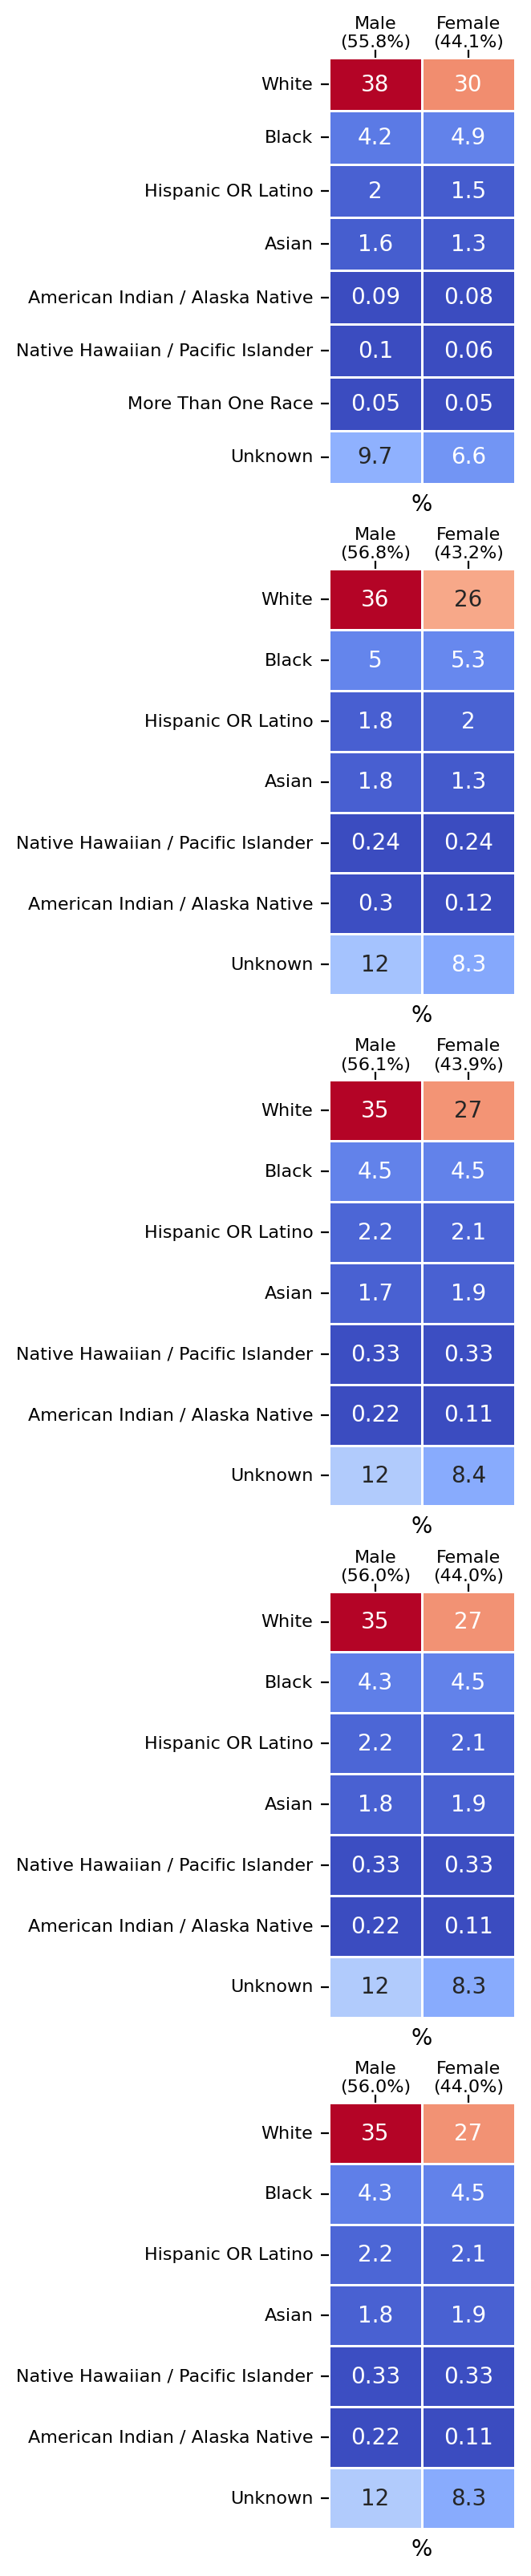

In [ ]:
demographics_heatmaps(mimic_iv)

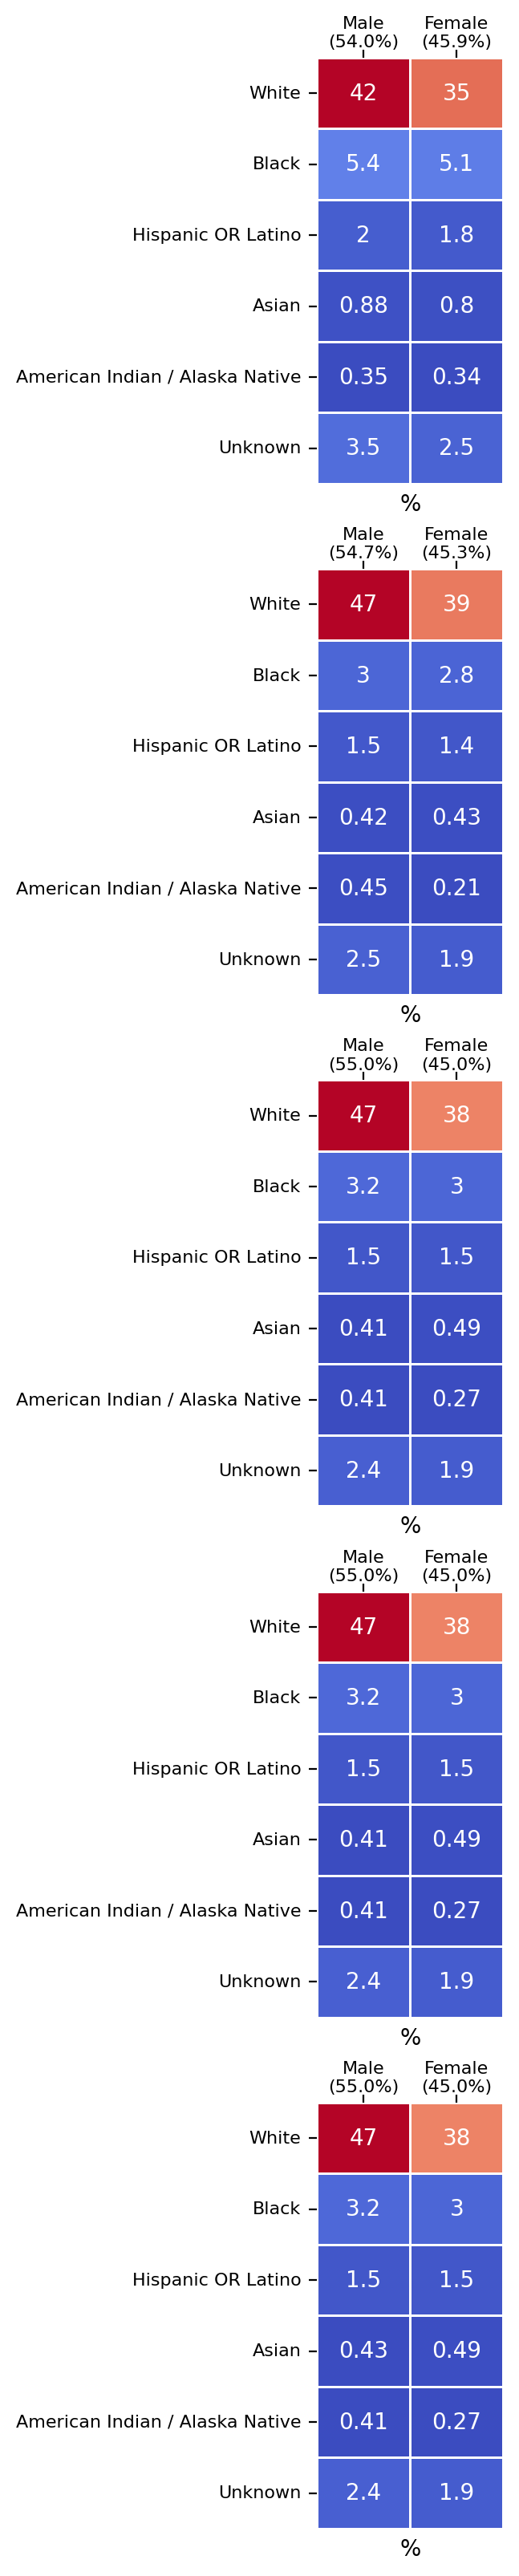

In [ ]:
demographics_heatmaps(eicu)

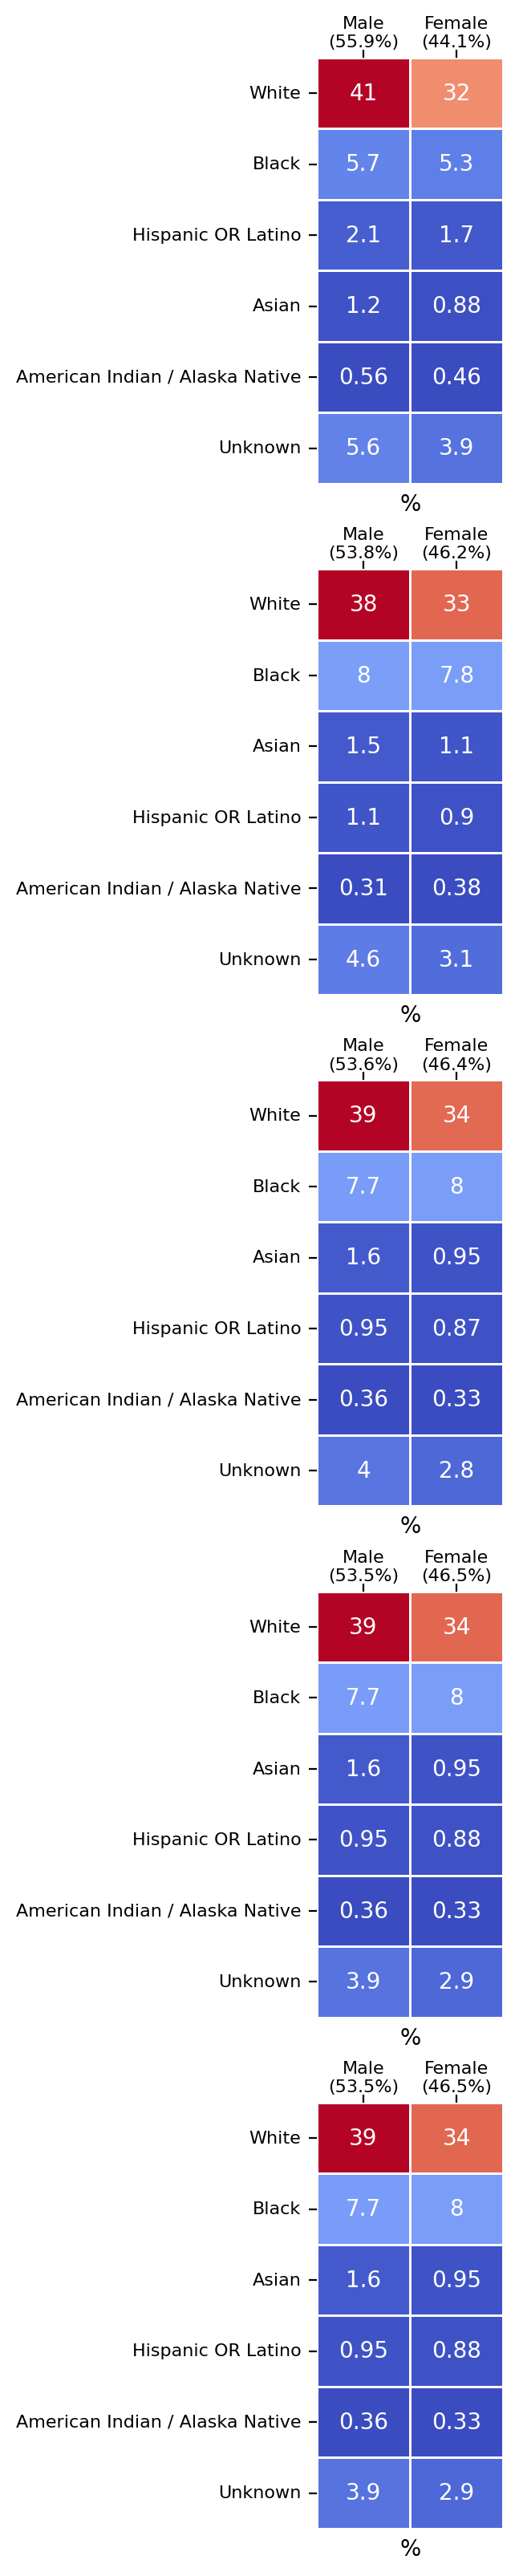

In [ ]:
demographics_heatmaps(eicu2)